In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from datetime import timedelta

C:\Users\41779\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\41779\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\41779\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [32]:
import lightgbm as lgb # Light GBM model
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
import logging

logging.basicConfig(
    filename='model_building.txt',
    level=logging.DEBUG,
    format='%(asctime)s.%(msecs)03d %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    filemode="a"

)


In [3]:
df=pd.read_csv("Train_Test_Preprocessing5")

C:\Users\41779\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df["date"] = pd.to_datetime(df["date"], infer_datetime_format=True, format="%Y%m%d")

In [ ]:
logging.info("Finale Featurizing of data started")

 #### <u> The most important task for this problem is time series featurization:</u>
  - credits : https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/82614
  <br>
              
  - since this is regression problem and most values are zero ., so we are going to solve this kind of probelms using hurdle models. (ref: https://seananderson.ca/2014/05/18/gamma-hurdle/).
    <br>

  - Here I will discuss the entire methodology for this idea.
  <br>
  
  - Basically the data which is given :
     - train data time period range is      : Aug 1'st 2016 to Apr 30'th 2018 => total 638 days.
     - test data time period range is       : may 1'st 2018 to oct 15'th 2018 => total 168 days.
     - Prediction data time period range is : Dec 1'st 2018 to Jan 31'st 2019 => total 62 days. 
  <br>
  
  
  - so here we need to predict the revenue of users in period of Dec 1st 2018 to jan 31'st 2019 by using the train and test data given to us.
  <br>
  
  - so we had data untill oct 15 th 2018 and prediction data begining date was dec 1st 2018., so the in between period is called "cooling period" and it is 46 days.
     - so here idea is first we need to predict whether the user will come to store or not after the "cooling period" of 46 days(or in test period). so for this we will use classificatio model
     - suppose if he will come to store then we will predict the revenue of that user by using regression model wih user data(features).
     
  <br>
  
  - so the next step is we need to build the data for classification model in such way that it will replicate the real world scenario
    - ##### <u> real world scenario</u> ? 
         - that means train data will consits of 168 days data and test data will consists of 62 days data and we will maintain the gap between the train data end date and test data begining date with 46 days.
         - so by usnig this train data we need to predict whether the user will come to store or not for test data that we prepared.
         - ex: 
              -  train data = Aug 1'st 2016 to jan 15'th 2017 (168 days)
              -  test  data = mar 2'nd 2017 to may 3'rd  2017 (62  days) 
              -  The gap between train and test data is 46 days
         - so by using the data that we had we can 4 make sets of tain and test
         
         - data set-1: 
              -  train data = Aug 1'st 2016 to jan 15'th 2017 (168 days)
              -  test  data = mar 2'nd 2017 to may 3'rd  2017 (62  days) 
         - data set-2: 
              -  train data = jan 16'st 2017 to jul 2'nd  2017 (168 days)
              -  test  data = aug 17'nd 2017 to  oct 18'th 2017 (62  days) 
         - data set-3: 
              -  train data = jul 3'rd 2017 to dec 17'th 2017 (168 days)
              -  test  data = feb 1'st 2018 to apr 4'th  2018 (62  days) 
         - data set-4: 
              -  train data = Dec 18'th 2017 to jun 4'th 2018 (168 days)
              -  test  data = jul 20'th 2018 to sep 20'th 2018 (62  days) 
         
   - so from above data sets for the users which are common in train and test(that means they returned after cooling period) we will create a new feature 'is_returned' and we will set it to 1., for the users which not returned we will set 'is_returned' to 0.
   - we will create some new features for the every user in 'train data' and finally we will merge all this dataframes.

In [4]:
def get_time_series_features(data,k):
    
    train_frame_k = data.loc[(data['date'] >= min(data['date']) + timedelta(days=168*(k-1))) 
                           & (data['date'] < min(data['date'])  + timedelta(days=168*k)) ]
    
    # for train_frame_1 = aug 1st 2016 to jan 15 th 2017
      #in code k=1 and min(data['date']) = aug 1st 2016
       # so it return from aug 1st 2016 to jan 15 th 2017 (since: aug 1st 2016+168)
    
    
    
    
    test_frame_k = data.loc[(data['date'] >= max(train_frame_k['date']) + timedelta(days=46)) 
                    & (data['date'] <= max(train_frame_k['date']) + timedelta(days=108))]
    
    # for test_frame_1 = mar 2nd 2017 to may 3 rd 2017
      #in code max(train_frame_k['date'])=jan 15th 2017
       # so it return from " mar 2nd 2017(since: jan 15 th 2017 + 46)" to "may 3rd 2017(since: jan 15 th 2017 + 108)"
    
    

    
    returned_customers     = set(train_frame_k["fullVisitorId"]) & set(test_frame_k["fullVisitorId"]) # intersection
    non_returned_customers = set(train_frame_k["fullVisitorId"]) - set(test_frame_k["fullVisitorId"]) # subtraction
    
    # here we will seperate the customers who came to store after cooling peroid untill 64 days after cooling period. 
    # Here cooling period means(=46 days) from "train_frame" end date
    #so now we will seperate the "train_frame_k" customers who came back to store in "test_frame_k" period.
    
    
    
    # preparing returned customers data:
    # ----------------------------------
    returned_customers_data = test_frame_k[test_frame_k['fullVisitorId'].isin(set(returned_customers))]  
    returned_customers_transactions = returned_customers_data.groupby('fullVisitorId')[['totals.transactionRevenue']]\
                                       .sum().apply(np.log1p, axis=1).reset_index()
    
    returned_customers_transactions['is_returned'] = 1
    returned_customers_transactions.rename(columns={'totals.transactionRevenue': 'revenue'}, inplace=True) 
    
    
    
    
    # preparing non-returned customers data:
    # ----------------------------------
    
    non_returned_customers_data                  = pd.DataFrame()
    non_returned_customers_data['fullVisitorId'] = list(set(non_returned_customers))
    non_returned_customers_data['is_returned']   = 0
    non_returned_customers_data['revenue']       = 0
    
    
    # so final time based featurizations(for classification model):
    #--------------------------------------------------------------------
    # we are concatinating returned and non-returned users 
    
    classification_features = pd.concat([returned_customers_transactions, non_returned_customers_data], axis=0)\
                              .reset_index(drop=True)
    
    
   
    
    # featurization for train_frame_k data :
    # ------------------------------------------
    #https://stackoverflow.com/questions/52747805/how-to-get-rid-of-nested-column-names-in-pandas-from-group-by-aggregation
    
    train_frame_k_maxdate = max(train_frame_k['date'])
    train_frame_k_mindate = min(train_frame_k['date'])
    
    train_frame_k = train_frame_k.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': [('networkDomain' , lambda x: x.dropna().max())], #max value of network domain
            'geoNetwork.city':          [('city' , lambda x: x.dropna().max())],  #max value of city
            'device.operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],  #max value of Operating System
            'geoNetwork.metro':         [('metro' , lambda x: x.dropna().max())],  #max value of metro
            'geoNetwork.region':        [('region' , lambda x: x.dropna().max())],   #max vaue of region
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],  #max value of channel grouping
          'trafficSource.referralPath': [('referralPath' , lambda x: x.dropna().max())],  #max value of referral path
            'geoNetwork.country':       [('country' , lambda x: x.dropna().max())],    #max value of country
            'trafficSource.source':     [('source' , lambda x: x.dropna().max())],   #max value of source
            'trafficSource.medium':     [('medium' , lambda x: x.dropna().max())],   #max value of medium

            'device.browser':           [('browser' , lambda x: x.dropna().max())],  #max value of browser
            'device.deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())], #max of device category
            'geoNetwork.continent':     [('continent' , lambda x: x.dropna().max())],      #max of continent value
            'geoNetwork.subContinent':  [('subcontinent' , lambda x: x.dropna().max())],  #max of sub_continent value
            'totals.timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),     # total timeonsite of user
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),     # max timeonsite
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  # mean timeonsite
            'totals.pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     # total of page views
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     # min of page views
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     # max of page views
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  # mean of page views
            'totals.hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     # total of hits
                                         ('hits_min'  , lambda x: x.dropna().min()),     # min of hits
                                         ('hits_max'  , lambda x: x.dropna().max()),     # max of hits
                                         ('hits_mean' , lambda x: x.dropna().mean())],  # mean of hits
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], #Count of visitStartTime
            'totals.sessionQualityDim': [('sessionQualityDim' , lambda x: x.dropna().max())], #Max value of sessionQualityDim
            'device.isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], #Max value of isMobile
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  #Maximum number of visits.
        #'totals.transactionRevenue':[('transactionRevenue_sum' , lambda x:x.dropna().sum())], #summation of all the transaction amounts.
            'totals.transactions' :     [('transactions' , lambda x:x.dropna().sum())], #Summation of all the transaction counts.
            'date':                     [('first_ses_from_the_period_start' , lambda x: x.dropna().min() - train_frame_k_mindate), #first shopping session for customer after the period end date for current frame.
                                         ('last_ses_from_the_period_end', lambda x: train_frame_k_maxdate - x.dropna().max()), #Last shopping session for customer before the period end date for current frame.
                                         ('interval_dates' , lambda x: x.dropna().max() - x.dropna().min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                                         ('unqiue_date_num' , lambda x: len(set(x.dropna())))] , # Unique number of dates customer visited.           
                                                         })

    
    # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group. 
    train_frame_k.columns = train_frame_k.columns.droplevel() 
    
    
    # merging the two dataframe tf having features and tf_target having target variables.
    train_frame_k = pd.merge(train_frame_k, classification_features , left_on='fullVisitorId', right_on='fullVisitorId') 
    
    
    return train_frame_k

In [5]:
%time train_frame_1 = get_time_series_features(df,1)
train_frame_1.to_pickle('train_frame_1')

Wall time: 16min 5s


In [6]:
%time train_frame_2 = get_time_series_features(df,2)
train_frame_2.to_pickle('train_frame_2')

Wall time: 12min 15s


In [7]:
%time train_frame_3 = get_time_series_features(df,3)
train_frame_3.to_pickle('train_frame_3')

Wall time: 53min 54s


In [9]:
%time train_frame_4 = get_time_series_features(df,4)
train_frame_4.to_pickle('train_frame_4')

Wall time: 17min 53s


Time-series featurization for test data:

In [17]:
def get_time_series_features_for_test(test_data):
    
    
    test_frame_k_maxdate = max(test_data['date'])
    test_frame_k_mindate = min(test_data['date'])
    
    test_frame_k = test_data.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': [('networkDomain' , lambda x: x.dropna().max())], #max value of network domain
            'geoNetwork.city':          [('city' , lambda x: x.dropna().max())],  #max value of city
            'device.operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],  #max value of Operating System
            'geoNetwork.metro':         [('metro' , lambda x: x.dropna().max())],  #max value of metro
            'geoNetwork.region':        [('region' , lambda x: x.dropna().max())],   #max vaue of region
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],  #max value of channel grouping
          'trafficSource.referralPath': [('referralPath' , lambda x: x.dropna().max())],  #max value of referral path
            'geoNetwork.country':       [('country' , lambda x: x.dropna().max())],    #max value of country
            'trafficSource.source':     [('source' , lambda x: x.dropna().max())],   #max value of source
            'trafficSource.medium':     [('medium' , lambda x: x.dropna().max())],   #max value of medium
            'device.browser':           [('browser' , lambda x: x.dropna().max())],  #max value of browser
            'device.deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())], #max of device category
            'geoNetwork.continent':     [('continent' , lambda x: x.dropna().max())],      #max of continent value
            'geoNetwork.subContinent':  [('subcontinent' , lambda x: x.dropna().max())],  #max of sub_continent value
            'totals.timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),     # total timeonsite of user
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),     # min timeonsite
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),     # max timeonsite
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  # mean timeonsite
            'totals.pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     # total of page views
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     # min of page views
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     # max of page views
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  # mean of page views
            'totals.hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     # total of hits
                                         ('hits_min'  , lambda x: x.dropna().min()),     # min of hits
                                         ('hits_max'  , lambda x: x.dropna().max()),     # max of hits
                                         ('hits_mean' , lambda x: x.dropna().mean())],  # mean of hits
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], #Count of visitStartTime
            'totals.sessionQualityDim': [('sessionQualityDim' , lambda x: x.dropna().max())], #Max value of sessionQualityDim
            'device.isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], #Max value of isMobile
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  #Maximum number of visits.
           # 'totals.transactionRevenue':[('transactionRevenue_sum' , lambda x:x.dropna().sum())], #summation of all the transaction amounts.
            'totals.transactions' :     [('transactions' , lambda x:x.dropna().sum())], #Summation of all the transaction counts.
            'date':                     [('first_ses_from_the_period_start' , lambda x: x.dropna().min() - test_frame_k_mindate), #first shopping session for customer after the period end date for current frame.
                                         ('last_ses_from_the_period_end', lambda x: test_frame_k_maxdate - x.dropna().max()), #Last shopping session for customer before the period end date for current frame.
                                         ('interval_dates' , lambda x: x.dropna().max() - x.dropna().min()),  #interval calculated as the latest date on which customer visited - oldest date on which they visited.
                                         ('unqiue_date_num' , lambda x: len(set(x.dropna())))] , # Unique number of dates customer visited.           
                                                         })

    
    # Drop the parent level of features. for e.g. drop geoNetwork.networkDomain and keep only 'networkDomain' which stores max value from the group. 
    test_frame_k.columns = test_frame_k.columns.droplevel() 
    
    return test_frame_k

In [18]:
test_df=df[(df["date"]>="2018-05-01")&(df["date"]<="2018-10-15")]
train_df=df[df["date"]<="2018-04-30"]

In [19]:
%time test_frame_5 = get_time_series_features_for_test(test_df)
test_frame_5 = test_frame_5.reset_index()

test_frame_5['revenue']     = np.nan
test_frame_5['is_returned'] = np.nan

test_frame_5.to_pickle('test_frame_5')

Wall time: 12min 17s


In [20]:
#reading pickle files:

tr1 = pd.read_pickle(r'train_frame_1')
tr2 = pd.read_pickle(r'train_frame_2')
tr3 = pd.read_pickle(r'train_frame_3')
tr4 = pd.read_pickle(r'train_frame_4')
tr5 = pd.read_pickle(r'test_frame_5')

In [21]:
#concatinating all our featurized frames: 

final_featurized_data = pd.concat([tr1, tr2, tr3, tr4, tr5], axis=0, sort=False).reset_index(drop=True)

In [41]:
#Convert the date calulcated field in days format:

final_featurized_data['interval_dates'] = final_featurized_data['interval_dates'].dt.days
final_featurized_data['first_ses_from_the_period_start'] = final_featurized_data['first_ses_from_the_period_start'].dt.days
final_featurized_data['last_ses_from_the_period_end'] = final_featurized_data['last_ses_from_the_period_end'].dt.days

In [45]:
final_featurized_data.to_pickle('final_featurized_data')

In [ ]:
logging.info("Finale Featurizing of data completed")

In [42]:
# for all our test records we already fill the 'revenue' column with 'null' values., 
# so here we are seperating our train and test records
logging.info("Train_Test Split")
train_df = final_featurized_data[final_featurized_data['revenue'].notnull()]
test_df  = final_featurized_data[final_featurized_data['revenue'].isnull()]

In [44]:
train_df.to_csv("preprocessed_train_df",index=False)
test_df.to_csv("preprocessed_test_df",index=False)

### 6.Model building:
### we are begining with "LightGBM model" for both classification and regression.
### 6.1 Hyper-parameter tuning for classification model :

In [28]:
logging.info("Model Parameter Defined")
gridParams = {
    'learning_rate': [0.005,0.01,0.015],    #Learning rate
    'n_estimators': [40,100,200],           #number of boosting iterations  
    'num_leaves': [6,8,12,15,16],           #number of leaves in full tree
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],               #Binary Classification model to predict whether customer will return during test window
    'metric' : ['binary_logloss'],          #Performance metric as "Binary Logloss"  
    'colsample_bytree' : [0.6, 0.8, 1],     #LightGBM will select 80% of features before training each tree
    'subsample' : [0.7,0.9, 1],             #this will randomly select part of data without resampling
    'reg_alpha' : [0,1],                    #L1 regularization
    'reg_lambda' : [0,1],                   #L2 regularization
    'max_leaves': [128,256,512],            #Maximum number of nodes to be added.   
    'min_child_samples' : [1,20]            #Minimum number of data points needed in a child (leaf) node.
            }

In [33]:
# definig model object:

model = lgb.LGBMClassifier()

In [36]:
target_columns = ['is_returned', 'revenue', 'fullVisitorId']

In [46]:
# RandomizedSearchCV to hypertune the parameters

grid = RandomizedSearchCV(model, 
                          gridParams,
                          cv=3)


# Run the Randomsearch cv on the train dataset to find tuned hyperparameters

%time grid.fit(train_df.drop(target_columns, axis=1) , train_df['is_returned'])


[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=512 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=15, max_leaves=512 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=15, max_leaves=512 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=15, max_leaves=512 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=12, max_leaves=256 will be igno

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.005, 0.01, 0.015],
                                        'max_leaves': [128, 256, 512],
                                        'metric': ['binary_logloss'],
                                        'min_child_samples': [1, 20],
                                        'n_estimators': [40, 100, 200],
                                        'num_leaves': [6, 8, 12, 15, 16],
                                        'objective': ['binary'],
                                        'reg_alpha': [0, 1],
                                        'reg_lambda': [0, 1],
                                        'subsample': [0.7, 0.9, 1]})

### 6.2 Hyper-parameter tuning for regression model :

In [48]:
gridParams = {
    'learning_rate': [0.005,0.01,0.015],   #Learning rate
    'n_estimators': [40,100,200],          #number of boosting iterations   
    'num_leaves': [6,8,12,15,16],          #number of leaves in full tree
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],          #Regression model to predict transaction amount
    'metric' : ['rmse'],                   #Performance metric as "RMSE
    'colsample_bytree' : [0.6, 0.8, 1],    #LightGBM will select 80% of features before training each tree
    'subsample' : [0.7,0.9, 1],            #this will randomly select part of data without resampling
    'reg_alpha' : [0,1],                   #L1 regularization
    'reg_lambda' : [0,1],                  #L2 regularization
    'max_leaves': [128,256,512],           #Maximum number of nodes to be added. 
    'min_child_samples' : [1,20]           #Minimum number of data points needed in a child (leaf) node.   
    }

In [49]:
# Define LightGBM Regressor model

model = lgb.LGBMRegressor()

In [54]:
# RandomizedSearchCV to hypertune the parameters

random_search = RandomizedSearchCV(model,
                                   gridParams,
                                   cv=3)

# Run the Randomsearch cv on the train dataset to find tuned hyperparameters

%time random_search.fit(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], train_df['revenue'][train_df['is_returned']==1])

[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=15, max_leaves=512 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=15, max_leaves=512 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=15, max_leaves=512 will be ignored. Current value: num_leaves=15
[LightGBM] [Warning] num_leaves is set=16, max_leaves=256 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] num_leaves is set=16, max_leaves=256 will be ig

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.005, 0.01, 0.015],
                                        'max_leaves': [128, 256, 512],
                                        'metric': ['rmse'],
                                        'min_child_samples': [1, 20],
                                        'n_estimators': [40, 100, 200],
                                        'num_leaves': [6, 8, 12, 15, 16],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 1],
                                        'reg_lambda': [0, 1],
                                        'subsample': [0.7, 0.9, 1]})

In [55]:
# Print the best parameters found

print(random_search.best_params_)
print(random_search.best_score_)

{'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'regression', 'num_leaves': 6, 'n_estimators': 200, 'min_child_samples': 1, 'metric': 'rmse', 'max_leaves': 128, 'learning_rate': 0.015, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt'}
0.07584493272588984


### 6.3 Run Final Model with Hyper tuned Parameters and final dataset after featurization:

In [56]:
# classification model params:
logging.info("Model training has been started")
params_lgb1 = {
        "objective" : "binary",                #Binary Classification model to predict whether customer will return during test window
        "metric" : "binary_logloss",           #Performance metric as "Binary Logloss"  
        "max_leaves": 128,                     #Maximum number of nodes to be added. 
        "num_leaves" : 16,                     #number of leaves in full tree    
        "min_child_samples" : 20,              #Minimum number of data points needed in a child (leaf) node.  
        "learning_rate" : 0.015,                #Learning rate
        "subsample" : 0.9,                     #this will randomly select part of data without resampling
        "colsample_bytree" : 1,              #LightGBM will select 80% of features before training each tree
        "bagging_frequency" : 1,               #Perform bagging at every k iteration
        "n_estimators" : 200,                  #number of boosting iterations
        "reg_alpha" : 0,                       #L1 regularization
        "reg_lambda": 1,                       #L2 regularization
        "boosting_type" : "gbdt"}

# regression model params:

params_lgb2 = {
        "objective" : "regression",                 #Regression model to predict transaction amount
        "metric" : "rmse",                          #Performance metric as "RMSE"
        "max_leaves": 128,                          #Maximum number of nodes to be added. 
        "num_leaves" : 8,                           #number of leaves in full tree
        "min_child_samples" : 20,                    #Minimum number of data points needed in a child (leaf) node.   
        "learning_rate" : 0.015,                     #Learning rate
        "subsample" : 0.9,                            #this will randomly select part of data without resampling
        "colsample_bytree" : 1,                   #LightGBM will select 80% of features before training each tree
        "bagging_frequency" : 1,                    #Perform bagging at every k iteration
        "n_estimators" : 100,                       #number of boosting iterations
        "reg_alpha" : 1,                            #L1 regularization
        "reg_lambda": 0,                            #L2 regularization
        "boosting_type" : "gbdt"}

logging.info("Model training has been completed")

In [57]:
# Define dataset for Classification model to determine whether customer would return during test time window.

dtrain_returned = lgb.Dataset(train_df.drop(target_columns, axis=1), label = train_df['is_returned'])


# Define dataset for Regression model, picking only the customers who returned during test time window.

dtrain_revenue = lgb.Dataset(train_df.drop(target_columns, axis=1)[train_df['is_returned']==1], 
                         label=train_df['revenue'][train_df['is_returned']==1])

In [58]:
lgb.Dataset(train_df.drop(target_columns, axis=1), label = train_df['is_returned'])

In [59]:
#Running Lightgbm model for 10 iterations and took average of those.


pr_lgb_sum = 0    #Variable to store predictions.

print('Training and predictions')

for i in range(10):     #Running the model for 10 iterations and would be taking average of those as final value.
    print('Interation number ', i)
    
    #Classification model to predict whether customer will return in test window.
    
    lgb_model1 = lgb.train(params_lgb1, dtrain_returned)
    pr_lgb     = lgb_model1.predict(test_df.drop(target_columns, axis=1))
    lgb_model1.save_model('lgb_model1_itr_' + str(i) + '.txt' )
    
    
    #Classification model to predict the transaction amount for the customers who returned in that time window.
    
    lgb_model2 = lgb.train(params_lgb2, dtrain_revenue)
    pr_lgb_ret = lgb_model2.predict(test_df.drop(target_columns, axis=1))
    lgb_model2.save_model('lgb_model2_itr_' + str(i) + '.txt' )
    
    #Calculating final prediction as product of above two amounts.
    pr_lgb_sum = pr_lgb_sum + pr_lgb*pr_lgb_ret

#Taking average value from above iterations the model was run.
pr_final2 = pr_lgb_sum/10

Training and predictions
Interation number  0


C:\Users\41779\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Info] Number of positive: 7717, number of negative: 1477933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4176
[LightGBM] [Info] Number of data points in the train set: 1485650, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005194 -> initscore=-5.254974
[LightGBM] [Info] Start training from score -5.254974
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128

Interation number  5
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=16, max_leaves=128 will be ignored. Current value: num_leaves=16
[LightGBM] [Info] Number of positive: 7717, number of negative: 1477933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4176
[LightGBM] [Info] Number of data points in the train set: 1485650, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005194 -> ini

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4176
[LightGBM] [Info] Number of data points in the train set: 1485650, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.005194 -> initscore=-5.254974
[LightGBM] [Info] Start training from score -5.254974
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] num_leaves is set=8, max_leaves=128 will be ignored. Current value: num_leaves=8
[LightGBM] [Warning] Auto-ch

In [60]:
# creating a data frame for predictions that we made for test data users:

pred_df = pd.DataFrame({"fullVisitorId":test_df["fullVisitorId"].values})
pred_df["PredictedLogRevenue"] = pr_final2
pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]

In [61]:
# converting the above data-frame to csv file (need to submit this fiel to kaggle)

pred_df.to_csv("lgb_models.csv", index=False)

In [65]:
k = pd.read_csv('preprocessed_test_df',dtype={'fullVisitorId': 'str'},index_col=0) 
k

,networkDomain,city,operatingSystem,metro,region,channelGrouping,referralPath,country,source,medium,...,sessionQualityDim,isMobile,visitNumber_max,transactions,first_ses_from_the_period_start,last_ses_from_the_period_end,interval_dates,unqiue_date_num,revenue,is_returned
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
1995526696366,28608,1095,0,128,302,4,3745,72,50,4,...,1.0,1,1,0.0,133,34,0,1,NaN,NaN
16367580689231,19245,993,4,128,326,2,3745,13,0,3,...,1.0,0,1,0.0,104,63,0,1,NaN,NaN
18966949534117,28608,860,3,103,73,4,3745,78,50,4,...,1.0,0,1,0.0,104,63,0,1,NaN,NaN
24844201502183,28608,857,3,103,73,6,3745,78,0,3,...,1.0,0,1,0.0,163,4,0,1,NaN,NaN
24845665201193,31408,1095,3,128,516,4,3745,78,50,4,...,1.0,0,1,0.0,63,104,0,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996140076021376297,2835,1095,6,128,516,4,3745,29,50,4,...,1.0,1,1,0.0,25,142,0,1,NaN,NaN
9996713313157347413,22903,395,4,128,183,4,3745,29,15,4,...,1.0,0,2,0.0,53,114,0,1,NaN,NaN
9997886961296372510,25253,1095,4,128,516,4,3745,54,50,4,...,1.0,0,2,0.0,94,73,0,1,NaN,NaN


In [71]:
k_1_true=df[(df["date"]>="2018-05-01")&(df["date"]<="2018-10-15")].groupby("fullVisitorId")[["totals.transactionRevenue"]].sum().apply(np.log1p, axis=1).reset_index()

In [72]:
res = pd.merge(pred_df, k_1_true , left_on='fullVisitorId', right_on='fullVisitorId') 

In [73]:
rms = np.sqrt(mean_squared_error(res['totals.transactionRevenue'], res['PredictedLogRevenue']))
print(rms)

2.0907237401078382


In [ ]:
logging.info("Predicted Database is ready")

In [74]:
lgb_model1.feature_importance()

array([ 11,   6, 233,  92,  92, 186,  12,  26, 324,  54, 176,  22,   4,
        22,   5,  54,  10,  48,   4,  71,  11,  24,  10,  31,   4,  22,
        77, 111,  22, 442,   0, 211, 405, 171,   7])

In [75]:
train_df.drop(target_columns, axis=1).columns

Index(['networkDomain', 'city', 'operatingSystem', 'metro', 'region',
       'channelGrouping', 'referralPath', 'country', 'source', 'medium',
       'browser', 'deviceCategory', 'continent', 'subcontinent',
       'timeOnSite_sum', 'timeOnSite_min', 'timeOnSite_max', 'timeOnSite_mean',
       'pageviews_sum', 'pageviews_min', 'pageviews_max', 'pageviews_mean',
       'hits_sum', 'hits_min', 'hits_max', 'hits_mean',
       'visitStartTime_counts', 'sessionQualityDim', 'isMobile',
       'visitNumber_max', 'transactions', 'first_ses_from_the_period_start',
       'last_ses_from_the_period_end', 'interval_dates', 'unqiue_date_num'],
      dtype='object')

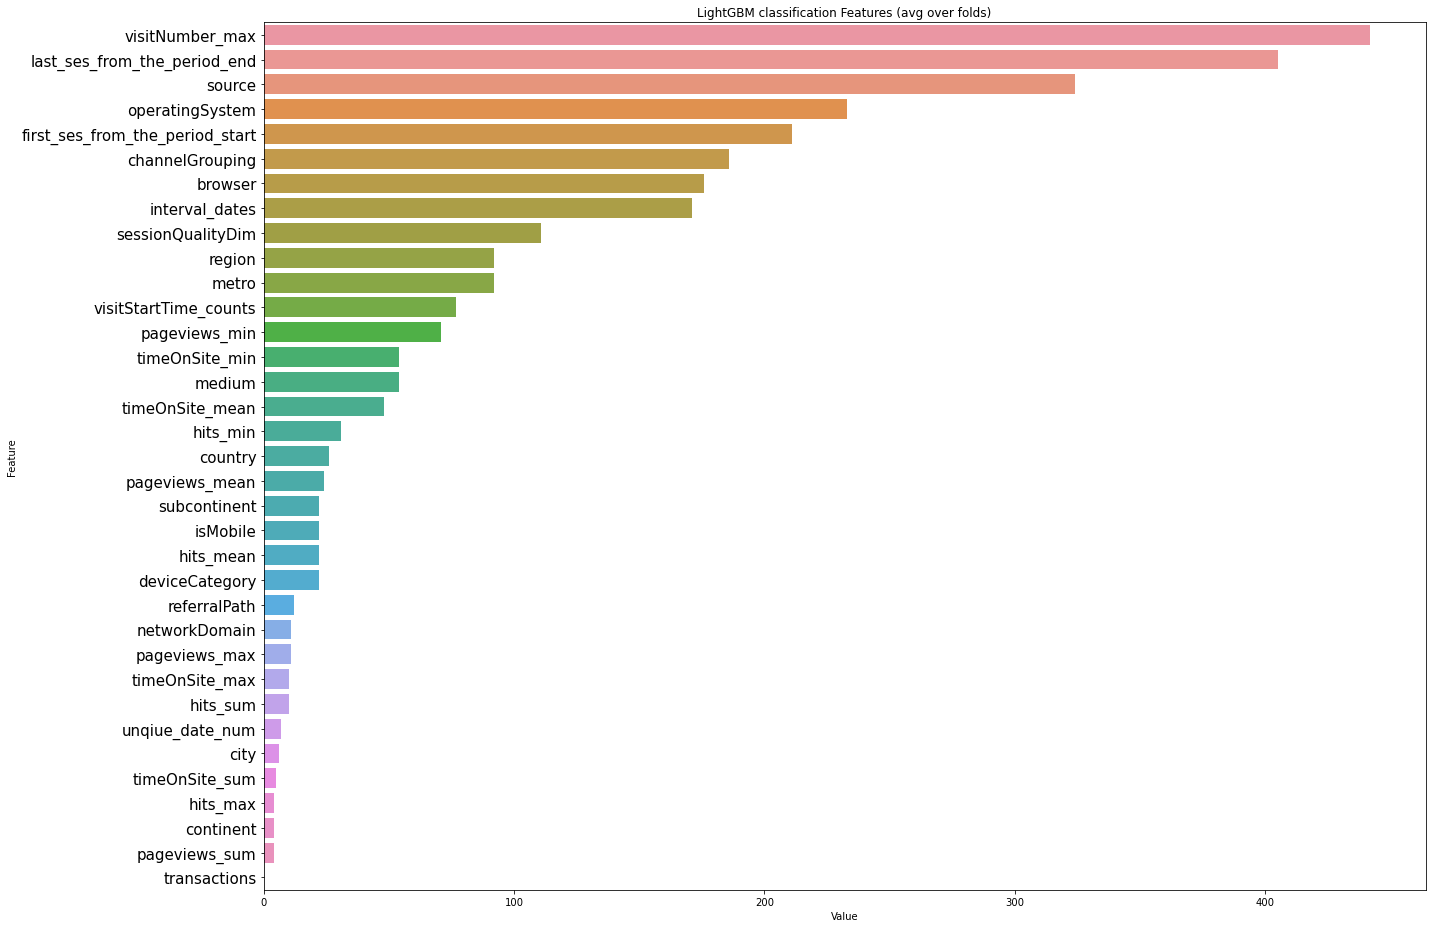

In [76]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgb_model1.feature_importance(), train_df.drop(target_columns, axis=1).columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 13))
plt.rc('ytick', labelsize=15) # y- axis value's font size
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM classification Features (avg over folds)')
plt.tight_layout()
plt.show()

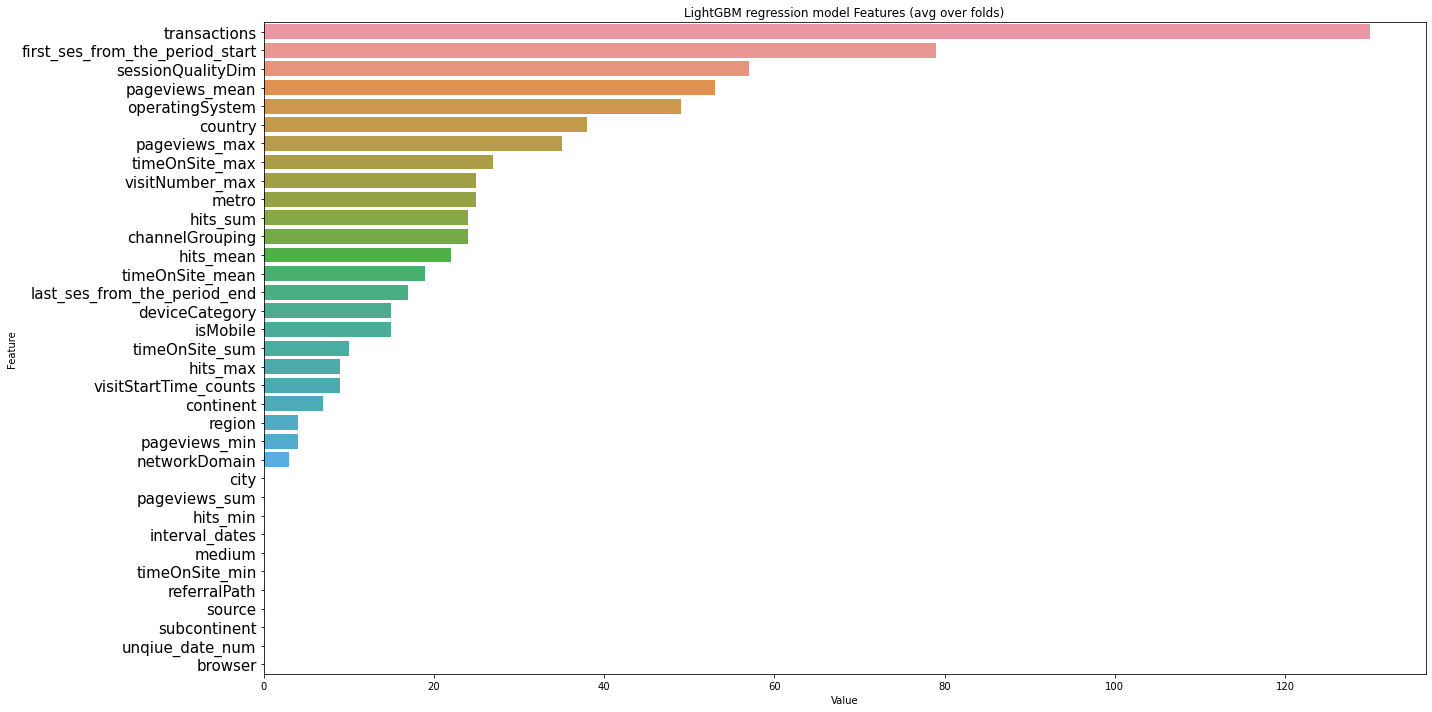

In [77]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgb_model2.feature_importance(),train_df.drop(target_columns, axis=1).columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
plt.rc('ytick', labelsize=15) # y- axis value's font size

sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM regression model Features (avg over folds)')
plt.tight_layout()
plt.show()